In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from pyhdf.SD import SD, SDC

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches

import networkx as nx 
from scipy.optimize import minimize

# Practice Dataset

In [4]:
file_path = 'MOD09GQ.20140906.GFGuy.NIR.hdf'

# Open the HDF4 file
hdf = SD(file_path, SDC.READ)

In [5]:
datasets = hdf.datasets()

In [6]:
# Observing feature names so can extract them
for idx, (name, info) in enumerate(datasets.items()):
    print(f"{idx+1}: Name: {name}, Info: {info}")

1: Name: num_observations, Info: (('YDim:MODIS_Grid_2D', 'XDim:MODIS_Grid_2D'), (4800, 4800), 20, 0)
2: Name: sur_refl_b01_1, Info: (('YDim:MODIS_Grid_2D', 'XDim:MODIS_Grid_2D'), (4800, 4800), 22, 1)
3: Name: sur_refl_b02_1, Info: (('YDim:MODIS_Grid_2D', 'XDim:MODIS_Grid_2D'), (4800, 4800), 22, 2)
4: Name: QC_250m_1, Info: (('YDim:MODIS_Grid_2D', 'XDim:MODIS_Grid_2D'), (4800, 4800), 23, 3)
5: Name: obscov_1, Info: (('YDim:MODIS_Grid_2D', 'XDim:MODIS_Grid_2D'), (4800, 4800), 20, 4)
6: Name: iobs_res_1, Info: (('YDim:MODIS_Grid_2D', 'XDim:MODIS_Grid_2D'), (4800, 4800), 21, 5)
7: Name: orbit_pnt_1, Info: (('YDim:MODIS_Grid_2D', 'XDim:MODIS_Grid_2D'), (4800, 4800), 20, 6)
8: Name: granule_pnt_1, Info: (('YDim:MODIS_Grid_2D', 'XDim:MODIS_Grid_2D'), (4800, 4800), 21, 7)


In [16]:
# extracting variables of interest
NIR = hdf.select('sur_refl_b02_1')[:]
red = hdf.select('sur_refl_b01_1')[:]

NIR_df = pd.DataFrame(NIR)
NIR_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,4790,4791,4792,4793,4794,4795,4796,4797,4798,4799
4795,3419,3455,3455,3538,3538,3618,3618,3618,3633,3633,...,2885,2912,3129,2873,2833,3001,3001,3244,2732,2956
4796,3415,3444,3444,3475,3538,3618,3618,3633,3633,3495,...,2900,2912,3111,2793,2603,2877,2951,2793,2793,2623
4797,3415,3444,3444,3475,3475,3495,3495,3531,3531,3489,...,2841,2928,3198,3030,2784,2976,2893,2694,2801,2801
4798,3367,3398,3398,3436,3475,3495,3495,3531,3531,3489,...,2841,3032,3286,3059,2701,2903,2923,2852,2832,2923
4799,3398,3398,3398,3436,3436,3492,3492,3495,3495,3472,...,3047,3143,3247,2930,2879,2896,2918,2852,2865,2925


In [7]:
# Changing index and column names to coordinates based on metadata, metadat found on the files originally imported 
resolution = 250  # meters
tile_dim = 4800  # pixels
tile_size_km = tile_dim * resolution / 1000  # tile size in km

# Bounding box coordinates from metadata
min_x = -60.9255967  
max_x = -49.8046541  
min_y = -0.0052966  
max_y = 10.0046099  

In [8]:
lon = np.linspace(min_x, max_x, tile_dim)
lat = np.linspace(min_y, max_y, tile_dim)

# Meshgrid for coords
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Flatten the grids to match DataFrame indexing
lon_flat = lon_grid.flatten()
lat_flat = lat_grid.flatten()

In [9]:
NIR_df.index = lat
NIR_df.columns = lon

In [10]:
# New dataframe with coordinates
NIR_df.tail()

,-60.925597,-60.923279,-60.920962,-60.918645,-60.916327,-60.914010,-60.911693,-60.909375,-60.907058,-60.904741,...,-49.825510,-49.823193,-49.820876,-49.818558,-49.816241,-49.813923,-49.811606,-49.809289,-49.806971,-49.804654
9.996267,3419,3455,3455,3538,3538,3618,3618,3618,3633,3633,...,2885,2912,3129,2873,2833,3001,3001,3244,2732,2956
9.998352,3415,3444,3444,3475,3538,3618,3618,3633,3633,3495,...,2900,2912,3111,2793,2603,2877,2951,2793,2793,2623
10.000438,3415,3444,3444,3475,3475,3495,3495,3531,3531,3489,...,2841,2928,3198,3030,2784,2976,2893,2694,2801,2801
10.002524,3367,3398,3398,3436,3475,3495,3495,3531,3531,3489,...,2841,3032,3286,3059,2701,2903,2923,2852,2832,2923
10.004610,3398,3398,3398,3436,3436,3492,3492,3495,3495,3472,...,3047,3143,3247,2930,2879,2896,2918,2852,2865,2925


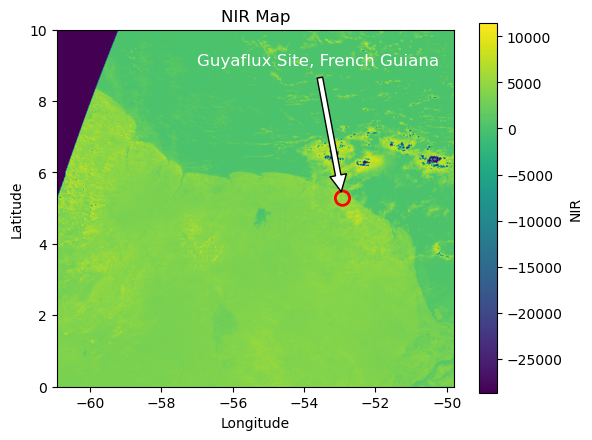

In [12]:
# Example plot
fig, ax = plt.subplots()
img_extent = (min_x, max_x, min_y, max_y)
img = ax.imshow(NIR, extent=img_extent, origin='upper', cmap='viridis')

highlight_lon = -52.9249
highlight_lat = 5.2788
radius = 0.2

circle = patches.Circle((highlight_lon, highlight_lat), radius, edgecolor='red', facecolor='none', linewidth=2)
ax.add_patch(circle)

ax.annotate('Guyaflux Site, French Guiana', xy=(highlight_lon, highlight_lat), xycoords='data',
            xytext=(-57, 9), textcoords='data', fontsize=12, color='white',
            arrowprops=dict(facecolor='white', shrink=0.05))

cbar = plt.colorbar(img, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('NIR')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NIR Map')
plt.show()

Finding recordings closest to site anf avaerging them for a final measure

In [13]:
nir_lat_idx = np.searchsorted(NIR_df.index, highlight_lat)
nir_lon_idx = np.searchsorted(NIR_df.columns, highlight_lon)

selected_nir = NIR_df.iloc[nir_lat_idx-1:nir_lat_idx+1, nir_lon_idx-1:nir_lon_idx+1]
selected_nir

,-52.926119,-52.923802
5.278115,2996,3144
5.280201,3645,3709


In [14]:
nir_avg = selected_nir.values.mean()
print(f'NIR Estimate for {highlight_lon, highlight_lat}: {nir_avg}')

NIR Estimate for (-52.9249, 5.2788): 3373.5


In [15]:
red_df = pd.DataFrame(red)
red_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,4790,4791,4792,4793,4794,4795,4796,4797,4798,4799
4795,336,339,339,322,322,333,333,333,329,329,...,1623,1591,1638,1661,1656,1782,1782,2122,1788,2087
4796,359,344,344,339,322,333,333,329,329,350,...,1667,1591,1532,1534,1558,1724,1879,1761,1761,1760
4797,359,344,344,339,339,350,350,334,334,362,...,1630,1608,1481,1478,1568,1747,1776,1651,1776,1776
4798,356,350,350,348,339,350,350,334,334,362,...,1630,1558,1450,1480,1554,1642,1680,1649,1741,1807
4799,350,350,350,348,348,339,339,342,342,348,...,1575,1508,1461,1556,1597,1638,1620,1649,1677,1707


In [16]:
red_df.index = lat
red_df.columns = lon

In [17]:
red_lat_idx = np.searchsorted(red_df.index, highlight_lat)
red_lon_idx = np.searchsorted(red_df.columns, highlight_lon)

selected_red = red_df.iloc[red_lat_idx-1:red_lat_idx+1, red_lon_idx-1:red_lon_idx+1]
selected_red

,-52.926119,-52.923802
5.278115,1921,2009
5.280201,2650,2681


In [18]:
red_avg = selected_red.values.mean()
print(f'Red Estimate for {highlight_lon, highlight_lat}: {red_avg}')

Red Estimate for (-52.9249, 5.2788): 2315.25


In [19]:
ndvi = (nir_avg - red_avg) / (nir_avg + red_avg)
ndvi

0.1860250494396836

Importing all data

In [29]:
# Site information and dates
sites_info = [
    {
        'site_name': 'DERus',
        'min_x': -0.0159131, 'max_x': 20.0205634, 
        'min_y': 49.7383725, 'max_y': 60.0101297,
        'highlight_lat': 50.8659, 'highlight_lon': 6.4471
    },
    {
        'site_name': 'AUTte', 
        'min_x': 127.3137014, 'max_x': 150.11107, 
        'min_y': -30.0666944, 'max_y': -19.8793592,
        'highlight_lat': -22.2870, 'highlight_lon': 133.6400
    },
    {
        'site_name': 'GFGuy', 
        'min_x': -60.9255967, 'max_x': -49.8046541, 
        'min_y': -0.0052966, 'max_y': 10.0046099,
        'highlight_lat': 5.2788, 'highlight_lon': -52.9249
    },
    {
        'site_name': 'USTw3', 
        'min_x': -130.5407289, 'max_x': -103.6998287, 
        'min_y': 29.8308029, 'max_y': 40.0852256,
        'highlight_lat': 38.1152, 'highlight_lon': -121.6470
    },
    {
        'site_name': 'USPfa', 
        'min_x': -109.0855079, 'max_x': -78.1496567, 
        'min_y': 39.7728386, 'max_y': 50.0921136,
        'highlight_lat': 45.9459, 'highlight_lon': -90.2723
    },
    {
        'site_name': 'GHAnk', 
        'min_x': -10.1542661, 'max_x': 0.0089568, 
        'min_y': -0.0004519, 'max_y': 10.0005849,
        'highlight_lat': 5.2685, 'highlight_lon': -2.6942
    },
    {
        'site_name': 'USSrm', 
        'min_x': -130.5407289, 'max_x': -103.6998287, 
        'min_y': 29.8308029, 'max_y': 40.0852256,
        'highlight_lat': 31.8214, 'highlight_lon': -110.8660
    },
    {
        'site_name': 'CHCha', 
        'min_x': -0.0086748, 'max_x': 15.5723927, 
        'min_y': 39.8144151, 'max_y': 50.006969,
        'highlight_lat': 47.2102, 'highlight_lon': 8.4104
    },
    {
        'site_name': 'ITCol', 
        'min_x': 12.9805304, 'max_x': 31.1317532, 
        'min_y': 39.8092441, 'max_y': 50.0181584,
        'highlight_lat': 41.8494, 'highlight_lon': 13.5881
    },
    {
        'site_name': 'USPfa', 
        'min_x': -109.0855079, 'max_x': -78.1496567, 
        'min_y': 39.7728386, 'max_y': 50.0921136,
        'highlight_lat': 45.8059, 'highlight_lon': -90.0799
    },
        {
        'site_name': 'AUCpr', 
        'min_x': 126.8653656, 'max_x': 156.7012821, 
        'min_y': -40.1080159, 'max_y': -29.8173661,
        'highlight_lat': -34.0021, 'highlight_lon': 140.5891
    },
    {
        'site_name': 'USSrm', 
        'min_x': -130.5407289, 'max_x': -103.6998287, 
        'min_y': 29.8308029, 'max_y': 40.0852256,
        'highlight_lat': 31.7365, 'highlight_lon': -109.9420
    },
    {
        'site_name': 'CHCha', 
        'min_x': -0.0086748, 'max_x': 15.5723927, 
        'min_y': 39.8144151, 'max_y': 50.006969,
        'highlight_lat': 47.8064, 'highlight_lon': 11.3275
    },
    {
        'site_name': 'USSrm', 
        'min_x': -130.5407289, 'max_x': -103.6998287, 
        'min_y': 29.8308029, 'max_y': 40.0852256,
        'highlight_lat': 31.7438, 'highlight_lon': -110.0520
    },
    {
        'site_name': 'CHCha', 
        'min_x': -0.0086748, 'max_x': 15.5723927, 
        'min_y': 39.8144151, 'max_y': 50.006969,
        'highlight_lat': 40.6062, 'highlight_lon': 8.1517
    },

]

dates = [
    '20140906', '20140907', '20140914', '20140917', '20140918', 
    '20140919', '20140921', '20140923', '20140925', '20141010',
    '20141011', '20141017', '20141018', '20141028', '20141031',
    '20141103', '20141105', '20141108', '20141212', '20141221',
    '20141222', '20141223', '20141226', '20141228', '20141230',
]

Importing function, includes all re-indexing and calculation of final readings per date per site

In [30]:
def process_hdf(file_path, min_x, max_x, min_y, max_y, highlight_lat, highlight_lon):
    # Open the HDF4 file
    hdf = SD(file_path, SDC.READ)

    NIR = hdf.select('sur_refl_b02_1')[:]
    red = hdf.select('sur_refl_b01_1')[:]

    tile_dim = 4800  # pixels
    lon = np.linspace(min_x, max_x, tile_dim)
    lat = np.linspace(min_y, max_y, tile_dim)

    NIR_df = pd.DataFrame(NIR, index=lat, columns=lon)
    red_df = pd.DataFrame(red, index=lat, columns=lon)

    nir_lat_idx = np.searchsorted(NIR_df.index, highlight_lat)
    nir_lon_idx = np.searchsorted(NIR_df.columns, highlight_lon)
    selected_nir = NIR_df.iloc[nir_lat_idx-1:nir_lat_idx+1, nir_lon_idx-1:nir_lon_idx+1]
    nir_avg = np.median(selected_nir)

    red_lat_idx = np.searchsorted(red_df.index, highlight_lat)
    red_lon_idx = np.searchsorted(red_df.columns, highlight_lon)
    selected_red = red_df.iloc[red_lat_idx-1:red_lat_idx+1, red_lon_idx-1:red_lon_idx+1]
    red_avg = np.median(selected_red)
    
    return nir_avg, red_avg

def process_all_datasets(sites_info, dates):
    results = []
    start = time.time()

    for i in range(len(sites_info)):
        loop_start = time.time()
        print(f'Now Processing Site {i}')
        site_name = sites_info[i]['site_name']
        min_x = sites_info[i]['min_x']
        max_x = sites_info[i]['max_x']
        min_y = sites_info[i]['min_y']
        max_y = sites_info[i]['max_y']
        highlight_lat = sites_info[i]['highlight_lat']
        highlight_lon = sites_info[i]['highlight_lon']

        for date in dates:
            file_path = f'MOD09GQ.{date}.{site_name}.NIR.hdf'

            nir_avg, red_avg = process_hdf(file_path, min_x, max_x, min_y, max_y, highlight_lat, highlight_lon)
                
            results.append({
                'Site': site_name,
                'Longitude': highlight_lon,
                'Latitude': highlight_lat,
                'Date': date,
                'NIR_avg': nir_avg,
                'Red_avg': red_avg
                })
        loop_end = time.time()
        loop_time = round(loop_end - loop_start, 2)
        print(f'Loop {i} complete, time taken: {loop_time} seconds')
    end = time.time()
    time_taken = round(end - start, 2)
    print(f'Overall Time Taken: {time_taken} seconds')
    return pd.DataFrame(results)

In [31]:
df_results = process_all_datasets(sites_info, dates)

Now Processing Site 0
Loop 0 complete, time taken: 56.79 seconds
Now Processing Site 1
Loop 1 complete, time taken: 39.44 seconds
Now Processing Site 2
Loop 2 complete, time taken: 43.45 seconds
Now Processing Site 3
Loop 3 complete, time taken: 44.99 seconds
Now Processing Site 4
Loop 4 complete, time taken: 41.61 seconds
Now Processing Site 5
Loop 5 complete, time taken: 37.98 seconds
Now Processing Site 6
Loop 6 complete, time taken: 42.38 seconds
Now Processing Site 7
Loop 7 complete, time taken: 45.84 seconds
Now Processing Site 8
Loop 8 complete, time taken: 41.95 seconds
Now Processing Site 9
Loop 9 complete, time taken: 40.52 seconds
Now Processing Site 10
Loop 10 complete, time taken: 35.67 seconds
Now Processing Site 11
Loop 11 complete, time taken: 41.43 seconds
Now Processing Site 12
Loop 12 complete, time taken: 42.56 seconds
Now Processing Site 13
Loop 13 complete, time taken: 41.94 seconds
Now Processing Site 14
Loop 14 complete, time taken: 42.71 seconds
Overall Time Ta

In [32]:
df_results

,Site,Longitude,Latitude,Date,NIR_avg,Red_avg
0,DERus,6.4471,50.8659,20140906,9005.5,9075.0
1,DERus,6.4471,50.8659,20140907,6450.0,6460.5
2,DERus,6.4471,50.8659,20140914,1785.5,320.0
3,DERus,6.4471,50.8659,20140917,1436.5,366.0
4,DERus,6.4471,50.8659,20140918,1875.5,307.5
...,...,...,...,...,...,...
370,CHCha,8.1517,40.6062,20141222,6556.0,6395.5
371,CHCha,8.1517,40.6062,20141223,5870.0,5851.5
372,CHCha,8.1517,40.6062,20141226,3101.0,2588.5
373,CHCha,8.1517,40.6062,20141228,4179.0,3348.5


Some sites were importing from same file due to proximity, renaming them based on latitude value

In [33]:
df_results.loc[df_results['Latitude'] == 40.6062, 'Site'] = 'ITNoe'
df_results.loc[df_results['Latitude'] == 31.7438, 'Site'] = 'USWhs'
df_results.loc[df_results['Latitude'] == 47.8064, 'Site'] = 'DESfn'
df_results.loc[df_results['Latitude'] == 31.7365, 'Site'] = 'USWkg'
df_results.loc[df_results['Latitude'] == 45.8059, 'Site'] = 'USWcr'

In [8]:
#df_results.to_excel('MODIS_data.xlsx')

In [34]:
df_results.shape

(375, 6)

In [35]:
# Scaling to correct metric
scale_factor = 0.0001
df_results['NIR_avg'] = df_results['NIR_avg'] * scale_factor
df_results['Red_avg'] = df_results['Red_avg'] * scale_factor
df_results.head()

,Site,Longitude,Latitude,Date,NIR_avg,Red_avg
0,DERus,6.4471,50.8659,20140906,0.90055,0.90750
1,DERus,6.4471,50.8659,20140907,0.64500,0.64605
2,DERus,6.4471,50.8659,20140914,0.17855,0.03200
3,DERus,6.4471,50.8659,20140917,0.14365,0.03660
4,DERus,6.4471,50.8659,20140918,0.18755,0.03075


Performing TDG Optimization

In [36]:
# Calculate site-specific mean without negative values
site_means = df_results[df_results['NIR_avg'] > 0].groupby('Site')['NIR_avg'].mean()

# Impute negative NIR values with site-specific means
df_results['Original_NIR_avg'] = df_results['NIR_avg']  # Keep a copy of original values
df_results['NIR_avg'] = df_results.apply(lambda row: site_means[row['Site']] if row['NIR_avg'] <= 0 else row['NIR_avg'], axis=1)

# Identify imputed values
imputed_mask = df_results['Original_NIR_avg'] <= 0
print('Initial imputation complete')

# Construct the Temporal-Difference Graph
G = nx.Graph()
for i in range(len(df_results)):
    G.add_node(i, value=df_results.iloc[i]['NIR_avg'])

k = 5  # Number of nearest neighbors for temporal connections
for i in range(len(df_results)):
    for j in range(1, k+1):
        if i+j < len(df_results) and df_results.iloc[i]['Site'] == df_results.iloc[i+j]['Site']:
            G.add_edge(i, i+j, weight=abs(df_results.iloc[i]['NIR_avg'] - df_results.iloc[i+j]['NIR_avg']))
            
print('Graph Constructed')

# Optimization
def objective_function(values):
    total_diff = 0
    for u, v, data in G.edges(data=True):
        total_diff += data['weight'] * (values[u] - values[v])**2
    return total_diff

constraints = [{'type': 'eq', 'fun': lambda values, i=i: values[i] - df_results.iloc[i]['NIR_avg']} 
               for i in range(len(df_results)) if not imputed_mask.iloc[i]]

initial_values = df_results['NIR_avg'].values

# Run the optimization
print("Starting optimization")
result = minimize(objective_function, initial_values, constraints=constraints, method='SLSQP')
print("Optimization complete")

df_results['Reconstructed_NIR_avg'] = result.x
df_results.head()

Initial imputation complete
Graph Constructed
Starting optimization
Optimization complete


,Site,Longitude,Latitude,Date,NIR_avg,Red_avg,Original_NIR_avg,Reconstructed_NIR_avg
0,DERus,6.4471,50.8659,20140906,0.90055,0.90750,0.90055,0.90055
1,DERus,6.4471,50.8659,20140907,0.64500,0.64605,0.64500,0.64500
2,DERus,6.4471,50.8659,20140914,0.17855,0.03200,0.17855,0.17855
3,DERus,6.4471,50.8659,20140917,0.14365,0.03660,0.14365,0.14365
4,DERus,6.4471,50.8659,20140918,0.18755,0.03075,0.18755,0.18755


In [38]:
# Calculate site-specific mean Red without negative values
site_means = df_results[df_results['Red_avg'] > 0].groupby('Site')['Red_avg'].mean()

# Impute negative Red values with site-specific means
df_results['Original_Red_avg'] = df_results['Red_avg']  # Keep a copy of original values
df_results['Red_avg'] = df_results.apply(lambda row: site_means[row['Site']] if row['Red_avg'] <= 0 else row['Red_avg'], axis=1)

# Identify imputed values
imputed_mask = df_results['Original_Red_avg'] <= 0
print('Initial imputation complete')

# Construct the Temporal-Difference Graph
G = nx.Graph()
for i in range(len(df_results)):
    G.add_node(i, value=df_results.iloc[i]['Red_avg'])

k = 5 
for i in range(len(df_results)):
    for j in range(1, k+1):
        if i+j < len(df_results) and df_results.iloc[i]['Site'] == df_results.iloc[i+j]['Site']:
            G.add_edge(i, i+j, weight=abs(df_results.iloc[i]['Red_avg'] - df_results.iloc[i+j]['Red_avg']))

# Optimization
def objective_function(values):
    total_diff = 0
    for u, v, data in G.edges(data=True):
        total_diff += data['weight'] * (values[u] - values[v])**2
    return total_diff

constraints = [{'type': 'eq', 'fun': lambda values, i=i: values[i] - df_results.iloc[i]['Red_avg']} 
               for i in range(len(df_results)) if not imputed_mask.iloc[i]]

initial_values = df_results['Red_avg'].values

# Run the optimization
print("Starting optimization")
result = minimize(objective_function, initial_values, constraints=constraints, method='SLSQP')
print("Optimization complete")

df_results['Reconstructed_Red_avg'] = result.x
df_results.head()

Initial imputation complete
Starting optimization
Optimization complete


,Site,Longitude,Latitude,Date,NIR_avg,Red_avg,Original_NIR_avg,Reconstructed_NIR_avg,Original_Red_avg,Reconstructed_Red_avg
0,DERus,6.4471,50.8659,20140906,0.90055,0.90750,0.90055,0.90055,0.90750,0.90750
1,DERus,6.4471,50.8659,20140907,0.64500,0.64605,0.64500,0.64500,0.64605,0.64605
2,DERus,6.4471,50.8659,20140914,0.17855,0.03200,0.17855,0.17855,0.03200,0.03200
3,DERus,6.4471,50.8659,20140917,0.14365,0.03660,0.14365,0.14365,0.03660,0.03660
4,DERus,6.4471,50.8659,20140918,0.18755,0.03075,0.18755,0.18755,0.03075,0.03075


In [39]:
df_results.drop(['NIR_avg', 'Original_NIR_avg', 'Red_avg', 'Original_Red_avg'], axis=1, inplace=True)
df_results.rename(columns={'Reconstructed_NIR_avg': 'NIR_avg', 'Reconstructed_Red_avg': 'Red_avg'}, inplace=True)
df_results.head(1)

,Site,Longitude,Latitude,Date,NIR_avg,Red_avg
0,DERus,6.4471,50.8659,20140906,0.90055,0.9075


NDVI calcualtion and reconstruction in same manner

In [40]:
df_results['NDVI'] = (df_results['NIR_avg'] - df_results['Red_avg']) / (df_results['NIR_avg'] + df_results['Red_avg'])

In [41]:
# Calculate site-specific mean NDVI without negative values
site_means = df_results[df_results['NDVI'] > 0].groupby('Site')['NDVI'].mean()

# Impute negative NDVI values with site-specific means
df_results['Original_NDVI'] = df_results['NDVI']  # Keep a copy of original values
df_results['NDVI'] = df_results.apply(lambda row: site_means[row['Site']] if row['NDVI'] <= 0 else row['NDVI'], axis=1)

# Identify imputed values
imputed_mask = df_results['Original_NDVI'] <= 0
print('Initial imputation complete')

# Construct the Temporal-Difference Graph
G = nx.Graph()
for i in range(len(df_results)):
    G.add_node(i, value=df_results.iloc[i]['NDVI'])

k = 5 
for i in range(len(df_results)):
    for j in range(1, k+1):
        if i+j < len(df_results) and df_results.iloc[i]['Site'] == df_results.iloc[i+j]['Site']:
            G.add_edge(i, i+j, weight=abs(df_results.iloc[i]['NDVI'] - df_results.iloc[i+j]['NDVI']))

# Optimization
def objective_function(values):
    total_diff = 0
    for u, v, data in G.edges(data=True):
        total_diff += data['weight'] * (values[u] - values[v])**2
    return total_diff

constraints = [{'type': 'eq', 'fun': lambda values, i=i: values[i] - df_results.iloc[i]['NDVI']} 
               for i in range(len(df_results)) if not imputed_mask.iloc[i]]

initial_values = df_results['NDVI'].values

# Run the optimization
print("Starting optimization")
result = minimize(objective_function, initial_values, constraints=constraints, method='SLSQP')
print("Optimization complete")

df_results['Reconstructed_NDVI'] = result.x
df_results.head()

Initial imputation complete
Starting optimization
Optimization complete


,Site,Longitude,Latitude,Date,NIR_avg,Red_avg,NDVI,Original_NDVI,Reconstructed_NDVI
0,DERus,6.4471,50.8659,20140906,0.90055,0.90750,0.252722,-0.003844,0.646783
1,DERus,6.4471,50.8659,20140907,0.64500,0.64605,0.252722,-0.000813,0.631874
2,DERus,6.4471,50.8659,20140914,0.17855,0.03200,0.696034,0.696034,0.696034
3,DERus,6.4471,50.8659,20140917,0.14365,0.03660,0.593897,0.593897,0.593897
4,DERus,6.4471,50.8659,20140918,0.18755,0.03075,0.718278,0.718278,0.718278


In [42]:
df_results.drop(['NDVI', 'Original_NDVI'], axis=1, inplace=True)
df_results.rename(columns={'Reconstructed_NDVI': 'NDVI'}, inplace=True)
df_results.head(1)

,Site,Longitude,Latitude,Date,NIR_avg,Red_avg,NDVI
0,DERus,6.4471,50.8659,20140906,0.90055,0.9075,0.646783


In [52]:
# Final dataset for MODIS
df_results['NIRv'] = round(df_results['NIR_avg'] * df_results['NDVI'],6)
df_results.head(5)

,Site,Longitude,Latitude,Date,NIR_avg,Red_avg,NDVI,NIRv
0,DERus,6.4471,50.8659,20140906,0.90055,0.90750,0.646783,0.582460
1,DERus,6.4471,50.8659,20140907,0.64500,0.64605,0.631874,0.407559
2,DERus,6.4471,50.8659,20140914,0.17855,0.03200,0.696034,0.124277
3,DERus,6.4471,50.8659,20140917,0.14365,0.03660,0.593897,0.085313
4,DERus,6.4471,50.8659,20140918,0.18755,0.03075,0.718278,0.134713


In [55]:
df_results.to_excel('MODIS_Final.xlsx')